<a href="https://colab.research.google.com/github/horstl/ProtFlow/blob/master/examples/colab_tutorials/ProtFlow_tutorial_binderdesign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to use ProtFlow to design a binder

This tutorial shows how how to employ [ProtFlow](https://github.com/mabr3112/ProtFlow) to for a custom made computational pipeline to design a binder for a protein ([EGFR receptor](https://en.wikipedia.org/wiki/Epidermal_growth_factor_receptor)). This tutorial ca be found as in a more extended version in the [documentation](https://protflow.readthedocs.io/en/updates-docs/tutorials/binder_design.html) of ProtFlow.
Detailed notebooks describing the differnt applications integrated can be found [here](https://github.com/mabr3112/ProtFlow/tree/master/examples).

# 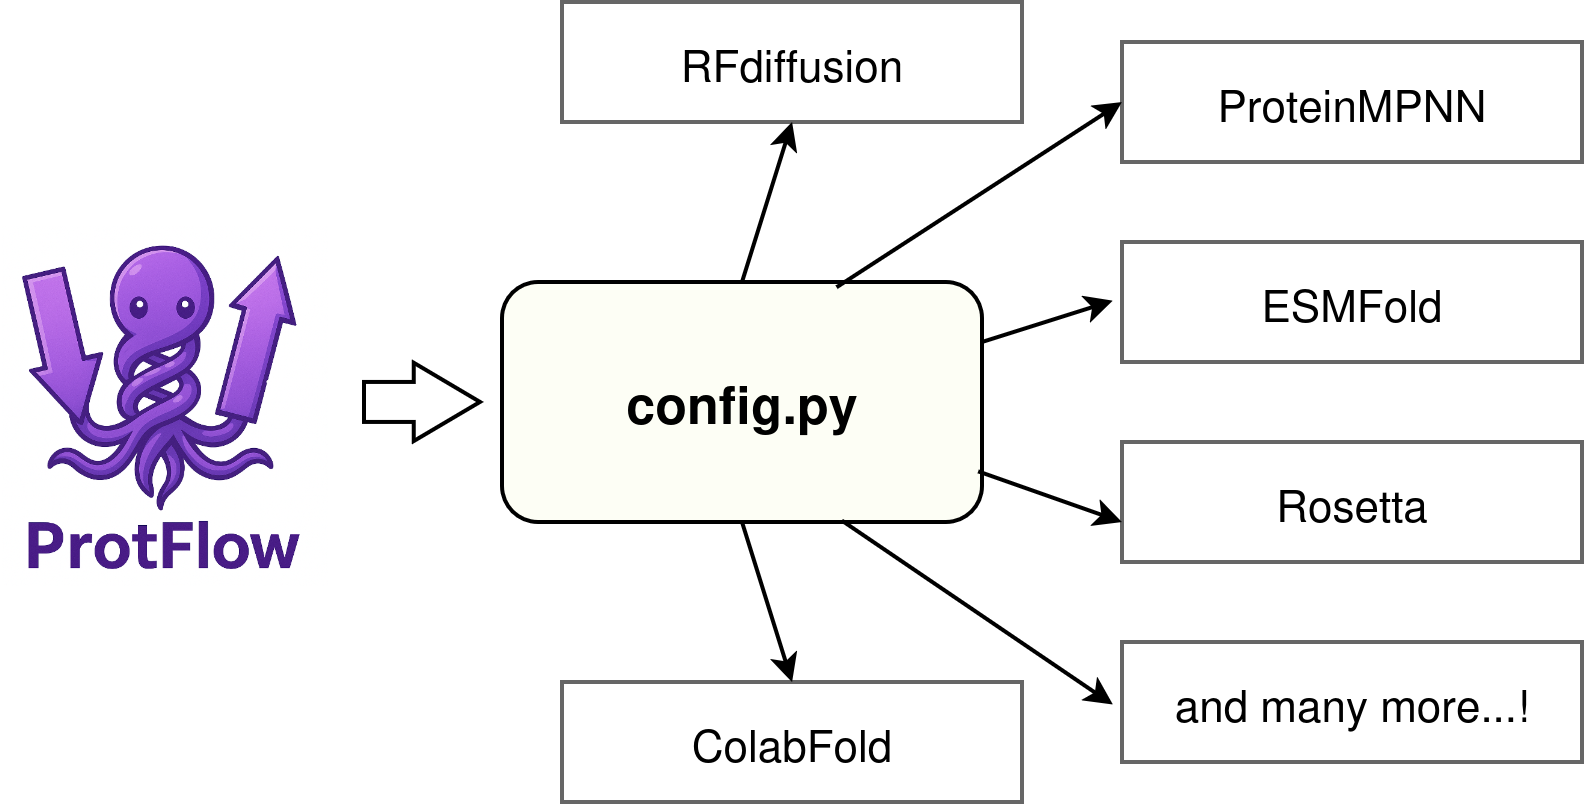

A pipeline similar to this one was used in the Adaptyv Bio's EGRF binder competition round 1 leading to a design ranking on [third place](https://www.adaptyvbio.com/blog/po102/).

The first 3 blocks will setup [RFDiffusion](https://github.com/RosettaCommons/RFdiffusion), [LigandMPNN](https://github.com/dauparas/LigandMPNN), [Boltz](https://github.com/jwohlwend/boltz) and [DSSP](https://github.com/PDB-REDO/dssp) (version 4.2.2) . Installation might take ~15-20 mins.

In [ ]:
# Installation

# ================================
# SYSTEM SETUP AND DEPENDENCIES
# ================================

# Check if running in Colab
try:
    import google.colab
    IN_COLAB = True
    print("✓ Running in Google Colab")
except ImportError:
    IN_COLAB = False
    print("✗ Not running in Google Colab")

# Mount Google Drive for persistent storage
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

# ================================
# MICROMAMBA ENVIRONMENT SETUP
# ================================
# Install micromamba in Google Colab
!wget -qO- https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xvj bin/micromamba

# Make it easier to call
!mkdir -p /usr/local/bin
!mv bin/micromamba /usr/local/bin/

# set enviorenment variable for micromamba
import os
os.environ['MAMBA_EXE'] = '/usr/local/bin/micromamba'
os.environ['MAMBA_ROOT_PREFIX'] = '/root/micromamba'





In [ ]:

# ================================
# DSSP INSTALL
# ================================
#!apt-get install dssp
#dssp version installed with apt in Sept 2025(dssp 4.0.4-1) is not accepting the pdb files generated, dssp version 4.2.2 does
#precompiled version will be downloaded with the needed library from the git repository

!wget https://raw.githubusercontent.com/mabr3112/ProtFlow/refs/heads/master/examples/colab_tutorials/files/mkdssp -O /usr/bin/mkdssp
!wget https://raw.githubusercontent.com/mabr3112/ProtFlow/refs/heads/master/examples/colab_tutorials/files/libcifpp.so.5 -O /usr/lib/x86_64-linux-gnu/libcifpp.so.5
!chmod 755 /usr/bin/mkdssp
print("✓ DSSP complete")


In [ ]:
# ================================
# LIGANDMPNN SETUP
# ================================

!git clone https://github.com/dauparas/LigandMPNN.git
%cd LigandMPNN
!bash get_model_params.sh "./model_params"

!micromamba create -y -n ligandmpnn -c conda-forge -c bioconda tmalign  python=3.11 git

!micromamba run -n ligandmpnn pip install -r requirements.txt
%cd /content

print("✓ LigandMPNN setup complete")

In [ ]:
# ================================
# BOLTZ SETUP
# ================================

%%bash
# --- Create env ---
micromamba create -y -n boltz python=3.10 -c conda-forge

# --- Install CUDA-enabled PyTorch ---
micromamba install -y -n boltz pytorch torchvision torchaudio pytorch-cuda=12.1 -c pytorch -c nvidia -c conda-forge

# --- Activate environment and install Boltz + deps ---
micromamba run -n boltz bash -c '
set -e
runtime="GPU(L4 or T4)"
deps="numpy hydra-core pytorch-lightning rdkit dm-tree requests pandas types-requests einops einx fairscale mashumaro modelcif wandb click pyyaml biopython scipy numba gemmi scikit-learn chembl_structure_pipeline cuequivariance_ops_cu12 cuequivariance_ops_torch_cu12 cuequivariance_torch"

if [[ "$runtime" == "GPU(L4 or T4)" ]]; then
  precision="32-true"
else
  precision="bf16-true"
fi

git clone https://github.com/jwohlwend/boltz.git /content/boltz
sed -i "s/bf16-mixed/${precision}/g" /content/boltz/src/boltz/main.py
pip install ipywidgets $deps
#cd /content/boltz && pip install --no-deps -e .
cd /content/boltz && pip install --no-deps .

echo "✅ Boltz environment setup complete."
'

In [ ]:

# ================================
# RFDIFFUSION ENVIROMENT SETUP
# ================================
%cd /content
!wget https://raw.githubusercontent.com/mabr3112/ProtFlow/refs/heads/master/examples/colab_tutorials/files/environment.yml
!micromamba create -y -f "/content/environment.yml"


print("✓ RFdiffusion setup complete")




In [ ]:
# ================================
# RFDIFFUSION DOWNLOAD & INSTALL
# ================================

!git clone https://github.com/RosettaCommons/RFdiffusion.git
%cd /content/RFdiffusion
#Get all the needed models
!mkdir -p models
!wget -O models/Base_ckpt.pt https://files.ipd.uw.edu/pub/RFdiffusion/6f5902ac237024bdd0c176cb93063dc4/Base_ckpt.pt
!wget -O models/Complex_base_ckpt.pt https://files.ipd.uw.edu/pub/RFdiffusion/e29311f6f1bf1af907f9ef9f44b8328b/Complex_base_ckpt.pt
!wget -O models/Complex_beta_ckpt.pt http://files.ipd.uw.edu/pub/RFdiffusion/f572d396fae9206628714fb2ce00f72e/Complex_beta_ckpt.pt
!micromamba run -n SE3nv pip install -e env/SE3Transformer
%cd /content/RFdiffusion/env/SE3Transformer/
!micromamba run -n SE3nv python setup.py install
%cd /content/RFdiffusion
!micromamba run -n SE3nv pip install -e .
%cd /content

print("✓ RFdiffusion setup complete")





# ProtFlow installation
Now we will install ProtFlow and a create a function to display the gained structures. Additonally a [config file](https://github.com/mabr3112/ProtFlow?tab=readme-ov-file#the-configuration-file) for ProtFlow is set up.

ProtFlow has following structure behind:
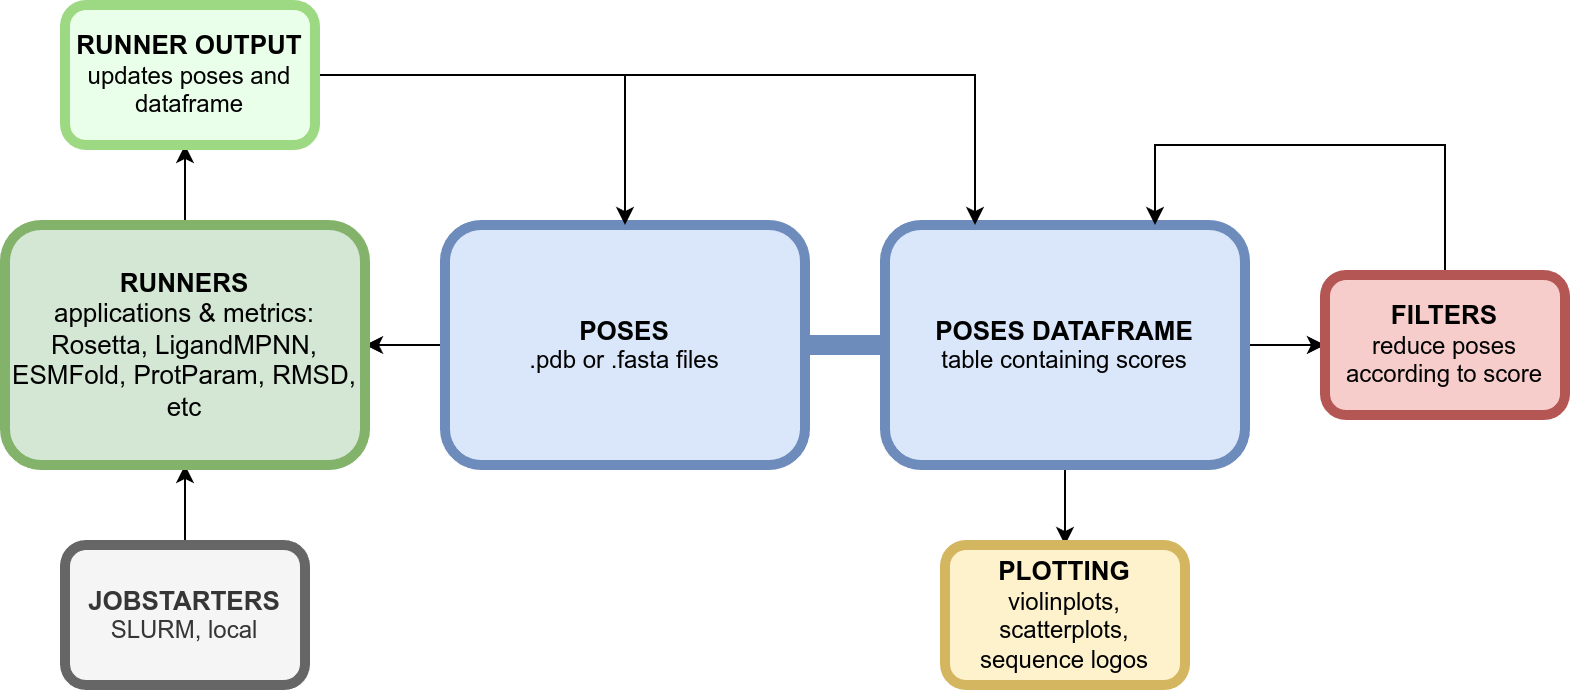

In [ ]:
"""
import sys
# --- Create environment with tmalign ---
!micromamba create -y -n tmalign -c conda-forge -c bioconda python=3.12.11 tmalign
!micromamba env list

# --- Get the env site-packages path ---
env_prefix = "/root/micromamba/envs/tmalign"
site_dir = f"{env_prefix}/lib/python3.12/site-packages"

# Add it to the Colab Python path so we can import from it
if site_dir not in sys.path:
    sys.path.insert(0, site_dir)

# Add TM-align binary to PATH
os.environ["PATH"] = f"{env_prefix}/bin:" + os.environ["PATH"]
"""

In [ ]:
#trial1
# ================================
# PROTFLOW SETUP
# ================================
import sys, os, site

# Go to workspace
%cd /content
# ProtFlow instalation
#!git clone https://github.com/mabr3112/ProtFlow.git
#%cd ProtFlow
#!/usr/bin/pip3 install -e .
#!pip install -e .
!{sys.executable} -m pip install git+https://github.com/mabr3112/ProtFlow.git


# --- Initialize ProtFlow config ---
!protflow-init-config
#sys.path.append("/content/ProtFlow")
#!ln -sf /usr/bin/python3 /usr/bin/python
%cd /content

# we need a "python" for the protflow config file
!ln -s /usr/bin/python3 /usr/bin/python
#linking TMalign to standard path
!ln -s /root/micromamba/envs/ligandmpnn/bin/TMalign /usr/bin/TMalign


print("✓ ProtFlow setup complete")


In [ ]:
%%writefile /root/.config/protflow/config.py
'''
This module contains all paths to tools integrated in ProtFlow. PRE_CMD are commands that should be run before the runner is executed (e.g. if import of a specific module is necessary for the environment to work)
'''
# path to root directory of ProtFlow:
PROTFLOW_DIR = "/content/ProtFlow/"

# protflow environment python
PROTFLOW_ENV = "/usr/bin/" # Corrected path to the base python executable

# auxiliary runners directory path
AUXILIARY_RUNNER_SCRIPTS_DIR = "/usr/local/lib/python3.12/dist-packages/protflow/tools/runners_auxiliary_scripts/"

# protein_generator.py
PROTEIN_GENERATOR_SCRIPT_PATH = "/usr/local/lib/python3.12/dist-packages/protflow/tools/runners_auxiliary_scripts/protein_generator.py"
PROTEIN_GENERATOR_PYTHON_PATH = ""

# ligandmpnn.py
LIGANDMPNN_SCRIPT_PATH =  "/content/ligandmpnn_repo/run.py"
LIGANDMPNN_PYTHON_PATH = "/root/micromamba/envs/ligandmpnn/bin/python"
LIGANDMPNN_PRE_CMD = "" # "echo 'this will be printed before running ligandmpnn'"

# rosetta.py
ROSETTA_BIN_PATH = "" # "/path/to/Rosetta/main/source/bin/"
ROSETTA_PRE_CMD = ""

# attnpacker.py
ATTNPACKER_PYTHON_PATH = "" # "/path/to/anaconda3/envs/attnpacker/bin/python3"
ATTNPACKER_DIR_PATH = "" # "/path/to/AttnPacker/"
ATTNPACKER_PRE_CMD = ""

# rfdiffusion.py
RFDIFFUSION_SCRIPT_PATH = "/content/RFdiffusion/scripts/run_inference.py"
RFDIFFUSION_PYTHON_PATH = "/root/micromamba/envs/SE3nv/bin/python"
RFDIFFUSION_PRE_CMD = ""

# esmfold.py
ESMFOLD_PYTHON_PATH = "" # "/path/to/miniconda3/envs/esm/bin/python"
ESMFOLD_PRE_CMD = ""

# af2
COLABFOLD_SCRIPT_PATH = "" # "/path/to/localcolabfold/colabfold-conda/bin/colabfold_batch"
COLABFOLD_PRE_CMD = ""

# fpocket
FPOCKET_PATH = "" # "/path/to/anaconda3/envs/protslurm/bin/fpocket"

# dssp
DSSP_PATH = "/usr/bin/mkdssp"

# boltz
BOLTZ_PATH = "/root/micromamba/envs/boltz/bin/boltz"
BOLTZ_PYTHON = "/root/micromamba/envs/boltz/bin/python3"
BOLTZ_PRE_CMD = ""

# gromacs
GROMACS_PATH = "" #/path/to/gromacs/bin/

# PLACER
PLACER_SCRIPT_PATH = "" # "/path/to/PLACER/run_PLACER.py"
PLACER_PYTHON_PATH = "" # "/path/to/mambaforge/envs/placer/bin/python"
PLACER_PRE_CMD = ""

# ESM
ESM_PYTHON_PATH = "" # "/path/to/package_manager/envs/your_esm_env/bin/python"
ESM_PRE_CMD = ""

# protein generator
PROTEIN_GENERATOR_PYTHON_PATH = ""
PROTEIN_GENERATOR_SCRIPT_PATH = "/usr/local/lib/python3.12/dist-packages/protflow/tools/runners_auxiliary_scripts/protein_generator.py"

In [ ]:
# ================================
# VIEWER SETUP
# ================================
!pip install py3Dmol biopython

import py3Dmol
import os
from itertools import combinations
import numpy as np
from Bio.PDB import PDBParser, NeighborSearch
import warnings
warnings.filterwarnings('ignore')


def calculate_interface_residues(pdb_data, distance_cutoff=10.0):
    """
    Calculate actual interface residues between chains based on distance.
    """
    try:
        # Write temporary file for BioPython parsing
        with open('temp.pdb', 'w') as f:
            f.write(pdb_data)

        parser = PDBParser(QUIET=True)
        structure = parser.get_structure('temp', 'temp.pdb')

        # Collect atoms per chain
        chain_atoms = {}
        for chain in structure.get_chains():
            chain_id = chain.get_id()
            atoms = []
            for residue in chain:
                for atom in residue:
                    if atom.element != 'H':  # Skip hydrogens
                        atoms.append((atom, residue.get_id()[1], chain_id))
            chain_atoms[chain_id] = atoms

        interface_residues = {}
        chain_ids = list(chain_atoms.keys())

        for i, chain1 in enumerate(chain_ids):
            for chain2 in chain_ids[i+1:]:
                atoms1 = [atom[0] for atom in chain_atoms[chain1]]
                atoms2 = [atom[0] for atom in chain_atoms[chain2]]

                if not atoms1 or not atoms2:
                    continue

                ns = NeighborSearch(atoms1)
                interface_res1, interface_res2 = set(), set()

                for atom in atoms2:
                    neighbors = ns.search(atom.coord, distance_cutoff)
                    if neighbors:
                        for neighbor in neighbors:
                            res_id = neighbor.get_parent().get_id()[1]
                            interface_res1.add(res_id)

                        res_id2 = atom.get_parent().get_id()[1]
                        interface_res2.add(res_id2)

                if interface_res1 and interface_res2:
                    interface_residues[(chain1, chain2)] = {
                        chain1: list(interface_res1),
                        chain2: list(interface_res2)
                    }

        if os.path.exists('temp.pdb'):
            os.remove('temp.pdb')

        return interface_residues
    except Exception as e:
        print(f"Warning: Could not calculate interfaces: {e}")
        return {}


def show_proteins_with_interfaces(pdb_list, width=400, height=400, grid_cols=2,
                                interface_cutoff=5.0, show_interface_surface=True,
                                color_by_plddt=False, highlight_residues=None):
    """
    Display multiple protein structures as cartoon,
    with each chain in a different color (or by pLDDT),
    and highlight inter-chain interfaces using distance cutoff.

    Parameters
    ----------
    pdb_list : list of str
        List of PDB filenames or raw PDB strings.
    width : int
        Width of each viewer.
    height : int
        Height of each viewer.
    grid_cols : int
        Number of columns in the grid layout.
    interface_cutoff : float
        Distance cutoff for interface detection (Angstroms).
    show_interface_surface : bool
        Whether to show surface at interfaces.
    color_by_plddt : bool
        If True, color by B-factor values interpreted as pLDDT scores.
        Uses AlphaFold color scheme: blue (high confidence) to red (low confidence).
    highlight_residues : str or list of str, optional
        Residues to highlight. Can be:
        - A single string like "B18,B39,B41,B108,B131"
        - A list of strings, one per structure: ["B18,B39", "A25,A30"]
        Format: chain_id + residue_number (e.g., "B18" = chain B, residue 18)
    """
    n = len(pdb_list)
    if n == 0:
        print("No PDB files provided!")
        return None

    # Simple chain color palette (expandable)
    chain_colors = [
        "red", "blue", "green", "orange", "purple", "cyan",
        "magenta", "yellow", "brown", "pink", "grey"
    ]

    # Parse highlight_residues
    highlight_list = []
    if highlight_residues is not None:
        if isinstance(highlight_residues, str):
            # Single string for all structures
            highlight_list = [highlight_residues] * n
        elif isinstance(highlight_residues, list):
            # List of strings, one per structure
            highlight_list = highlight_residues + [None] * (n - len(highlight_list))
        else:
            print("Warning: highlight_residues must be a string or list of strings")
            highlight_list = [None] * n
    else:
        highlight_list = [None] * n

    grid_rows = (n + grid_cols - 1) // grid_cols
    view = py3Dmol.view(width=width*grid_cols, height=height*grid_rows,
                        viewergrid=(grid_rows, grid_cols))

    for i, pdb in enumerate(pdb_list):
        try:
            # Load PDB
            if isinstance(pdb, str) and pdb.endswith(".pdb") and os.path.exists(pdb):
                with open(pdb, 'r') as f:
                    pdb_data = f.read()
                title = os.path.basename(pdb)
            else:
                pdb_data = pdb
                title = f"Structure {i+1}"

            row, col = divmod(i, grid_cols)

            # Add model
            view.addModel(pdb_data, "pdb", viewer=(row, col))

            # Detect chains
            chains = set()
            for line in pdb_data.splitlines():
                if line.startswith(("ATOM", "HETATM")):
                    chain_id = line[21].strip()
                    if chain_id:
                        chains.add(chain_id)

            chains = sorted(list(chains))
            print(f"{title}: Found chains {chains}")

            # Color scheme selection
            if color_by_plddt:
                # pLDDT coloring using AlphaFold color scheme
                # pLDDT scale: 0-50 (red), 50-70 (yellow), 70-90 (cyan), 90-100 (blue)
                view.setStyle(
                    {},
                    {"cartoon": {
                        "colorscheme": {
                            "prop": "b",
                            "gradient": "roygb",
                            "min": 0,
                            "max": 100
                        }
                    }},
                    viewer=(row, col)
                )
                print(f"{title}: Colored by pLDDT (B-factor)")
            else:
                # Color each chain distinctly
                for j, chain in enumerate(chains):
                    color = chain_colors[j % len(chain_colors)]
                    view.setStyle(
                        {"chain": chain},
                        {"cartoon": {"color": color}},
                        viewer=(row, col)
                    )
                print(f"{title}: Colored by chain")

            # Highlight interfaces if multiple chains
            if len(chains) > 1:
                interface_residues = calculate_interface_residues(pdb_data, interface_cutoff)
                if interface_residues:
                    print(f"{title}: Found {len(interface_residues)} interface(s)")
                    for (chain1, chain2), residues in interface_residues.items():
                        for chain, res_list in residues.items():
                            for res_num in res_list:
                                view.addStyle(
                                    {"chain": chain, "resi": res_num},
                                    {"stick": {"colorscheme": "redCarbon", "radius": 0.3}},
                                    viewer=(row, col)
                                )
                                if show_interface_surface:
                                    view.addStyle(
                                        {"chain": chain, "resi": res_list},
                                        {"surface": {"opacity": 0.6, "color": "red"}},
                                        viewer=(row, col)
                                    )
                else:
                    print(f"{title}: No interfaces found within {interface_cutoff}Å")

            # Highlight specific residues if provided
            highlight_spec = highlight_list[i]
            if highlight_spec:
                try:
                    # Parse residue specification: "B18,B39,B41,B108,B131"
                    residue_specs = [s.strip() for s in highlight_spec.split(',')]
                    highlighted_count = 0

                    for res_spec in residue_specs:
                        if len(res_spec) < 2:
                            continue

                        # Extract chain (first character) and residue number (rest)
                        chain_id = res_spec[0]
                        try:
                            res_num = int(res_spec[1:])
                        except ValueError:
                            print(f"Warning: Could not parse residue '{res_spec}'")
                            continue

                        # Highlight with sphere and stick representation
                        view.addStyle(
                            {"chain": chain_id, "resi": res_num},
                            {"sphere": {"color": "yellow", "radius": 1.0}},
                            viewer=(row, col)
                        )
                        view.addStyle(
                            {"chain": chain_id, "resi": res_num},
                            {"stick": {"color": "yellow", "radius": 0.5}},
                            viewer=(row, col)
                        )
                        highlighted_count += 1

                    if highlighted_count > 0:
                        print(f"{title}: Highlighted {highlighted_count} residue(s)")

                except Exception as e:
                    print(f"Error highlighting residues for {title}: {e}")

            view.addLabel(title, {"position": {"x": 0, "y": 0, "z": 0},
                                  "backgroundColor": "black", "fontColor": "white"},
                          viewer=(row, col))

            view.zoomTo(viewer=(row, col))

        except Exception as e:
            print(f"Error processing {pdb}: {e}")
            continue

    return view


# ================================
# USAGE EXAMPLES
# ================================

# Example 1: Regular chain coloring
# pdb_files = ["structure1.pdb", "structure2.pdb", "structure3.pdb"]
# viewer = show_proteins_with_interfaces(pdb_files, width=500, height=400, grid_cols=2)
# viewer.show()

# Example 2: pLDDT coloring (for AlphaFold/predicted structures)
# pdb_files = ["alphafold_structure1.pdb", "alphafold_structure2.pdb"]
# viewer = show_proteins_with_interfaces(
#     pdb_files,
#     width=500,
#     height=400,
#     grid_cols=2,
#     color_by_plddt=True
# )
# viewer.show()

# Example 3: Adjust interface cutoff
# viewer = show_proteins_with_interfaces(
#     pdb_files,
#     width=500,
#     height=400,
#     grid_cols=2,
#     interface_cutoff=8.0,  # More permissive interface detection
#     show_interface_surface=False  # Don't show surface
# )
# viewer.show()

# In case of interruption of the ProtFlow pipeline
If your workflow is interrupted or the connection to your ressources is lost you can continue your pipeline by simply using this code snipplet to reload the poses from your google drive.


```
#import importlib
#import protflow
#importlib.reload(protflow)

from protflow.poses import Poses
output_dir = "drive/MyDrive/ProtFlow_bindertutorial_output/"

poses_instance = Poses()
poses=poses_instance.load_poses(output_dir+'/ProtFlow_bindertutorial_output_scores.json')
poses.set_work_dir(output_dir)
display(poses.df)
```



# 1.Load a pdb as pose and define hotspot residues

In [ ]:
from protflow.poses import Poses
from protflow.residues import residue_selection

#create directory for output on you google drive and copy input pdb for the tutorial
!mkdir -p /content/drive/MyDrive/ProtFlow_bindertutorial_output/
!wget https://raw.githubusercontent.com/TecnomaLaser/ProtFlow-binder-design-tutorial/refs/heads/main/input/egfr_truncated.pdb -O drive/MyDrive/ProtFlow_bindertutorial_output/egfr_truncated.pdb


#define input pdb and output directory
receptor_pdb = "/content/drive/MyDrive/ProtFlow_bindertutorial_output/egfr_truncated.pdb"
output_dir = "/content/drive/MyDrive/ProtFlow_bindertutorial_output"

# import all PDB files in input dir as poses
poses = Poses(poses=receptor_pdb, work_dir=output_dir)

hotspot_residues = "B18,B39,B41,B108,B131" # residue numbers are different in the truncated EGFR!
hotspot_residue_selection = residue_selection(hotspot_residues, delim=",")

# add hotspot residues to poses df
# assign each pose the residue selection of the hotspot residues
poses.df["hotspot_residues_original"] = [hotspot_residue_selection for _ in poses.poses_list()]

# this residue selection will be updated post-diffusion (to track changing residue numbers)
poses.df["hotspot_residues_postdiffusion"] = [hotspot_residue_selection for _ in poses.poses_list()]
display(poses.df)

The structure of the truncated EGRF receptor is shown below, residues used as hotspot residues to design a binder are highlighted as yellow spheres.

In [ ]:
pdb_files = poses.df["poses"].to_list()
show_proteins_with_interfaces(pdb_files, highlight_residues="B18,B39,B41,B108,B131",grid_cols=1,show_interface_surface=False)


#2. RFdiffusion (~15 mins)
Now we are going to run to get backbones with a lenght of 80 residues binding around the defined hotspot residues. For this tutorial we are goning to make 5 backbones only - for a real problem you increase this number to a much higher number (100s-1000s)

In [ ]:
from protflow.utils.biopython_tools import load_structure_from_pdbfile, get_sequence_from_pose
from protflow.jobstarters import LocalJobStarter
from protflow.tools.rfdiffusion import RFdiffusion


# set up jobstarters
jobstarter = LocalJobStarter(max_cores=1)  # set up a jobstarter
rfdiffusion = RFdiffusion(jobstarter=jobstarter)  # set up rfdiffusion

# define diffusion contig (B1-162 is the receptor EGFR, binder should be 80 residues)
contig = "B1-162/0 80-80"
# define path to Beta model (comes with RFdiffusion)
beta_model_path = "/content/RFdiffusion/models/Complex_beta_ckpt.pt"

# rfdiffusion options, same as whenever hen running rfdiffusion on the cmd line
diff_opts = f"diffuser.T=50 'contigmap.contigs=[{contig}]' 'ppi.hotspot_res=[{hotspot_residues}]' inference.ckpt_override_path={beta_model_path}"

# run rfdiffusion
rfdiffusion.run(
    poses=poses,
    prefix='rfdiff',
    num_diffusions=4, # roughly 3 min/per design
    options=diff_opts,
    fail_on_missing_output_poses=False,
    update_motifs=['hotspot_residues_postdiffusion'],
)
display(poses.df)


In [ ]:
pdb_files = poses.df["poses"].to_list()
show_proteins_with_interfaces(pdb_files, width=500, height=400, grid_cols=2, show_interface_surface=True)

# 3. Selecting backbones and subsequent sequence design
For this several filters are applied to calculate the number of residues in close contact to each other, the radius of gyration (ROG) to select for "compactness" of the diffused scaffold as well a dssp module, to get a feeling about the secondary structure sontent of your designs.
The results are plotted and some filters are applied.

In [ ]:
from protflow.metrics.dssp import DSSP
from protflow.metrics.ligand import LigandContacts
from protflow.metrics.generic_metric_runner import GenericMetric
from protflow.residues import residue_selection # Import ResidueSelection

# set up metrics to calculate scores
contacts = LigandContacts(ligand_chain="B", min_dist=0, max_dist=10, atoms=['CA'], jobstarter=jobstarter) # calculates number of C-alpha atoms within 10 Angstrom of any atom that is on chain B
# the generic metric runner can run any function that takes a pose as input using a jobstarter
# Explicitly set python_path for GenericMetric to use the protflow environment
rog_calculator = GenericMetric(module="protflow.utils.metrics", function="calc_rog_of_pdb", options={"chain": "A"}, jobstarter=jobstarter) # calculates radius of gyration for chain A
# Explicitly set python_path for GenericMetric to use the protflow environment
rescontacts_calculator = GenericMetric(module="protflow.utils.metrics", function="residue_contacts", jobstarter=jobstarter) # calculates number of atoms/residues that are within a certain distance from a target atom or residue
dssp = DSSP(jobstarter=jobstarter) # calculates secondary structure content

# retrieve updated hotspot residues (same for all diffused backbones, as length of diffused backbones is always 80 residues)
hotspot_residues_postdiffusion = poses.df["hotspot_residues_original"].iloc[0]

# calculate rog, general contacts and hotspot contacts
rog_calculator.run(poses=poses, prefix="rfdiff_rog") # calculate ROG
contacts.run(poses=poses, prefix="rfdiff_contacts", normalize_by_num_atoms=False) # calculate number of contacts between chain A and B
dssp.run(poses=poses, prefix="dssp") # determine secondary structure content
# calculate number of contacts for each hotspot residue
for res in hotspot_residues_postdiffusion.to_list(): # iterate over hotspot residues
   chain, resnum = [res[0], res[1:]] # extract chain and residue number
   rescontact_opts={"max_distance": 12, "target_chain": chain, "partner_chain": "A", "target_resnum": int(resnum), "target_atom_names": ["CA"], "partner_atom_names": ["CA"]} # define options
   print (rescontact_opts)
   rescontacts_calculator.run(poses=poses, prefix=f"hotspot_{res}_contacts", options=rescontact_opts)
# calculate overall hotspot contacts
poses.df["hotspot_contacts"] = sum([poses.df[f"hotspot_{res}_contacts_data"] for res in hotspot_residues_postdiffusion.to_list()])

In [ ]:
from protflow.utils.plotting import violinplot_multiple_cols

# make a plot of the hotspot_contacts
cols_contact = ["rfdiff_plddt" , "rfdiff_rog_data", "hotspot_contacts"] + [f"hotspot_{res[0]}{res[1:]}_contacts_data" for res in hotspot_residues_postdiffusion.to_list()] # show contacts for each individual hotspot residue
violinplot_multiple_cols(dataframe=poses.df, cols=cols_contact, y_labels=cols_contact, out_path=os.path.join(poses.plots_dir, "diff_contacts.png"))

# make a plot of the secondary structure content
ss_content_cols = [col for col in poses.df.columns if col.startswith("dssp") and col.endswith("content")] # show content for each secondary structure element
violinplot_multiple_cols(dataframe=poses.df, cols=ss_content_cols, y_labels=ss_content_cols, out_path=os.path.join(poses.plots_dir, "diff_ss_content.png"))

In [ ]:
# we filter poses by the given criteria
poses.filter_poses_by_value(score_col="rfdiff_rog_data", value=18, operator="<=", prefix="rfdiff_rog", plot=True) # remove all poses with ROG higher than 20
poses.filter_poses_by_value(score_col="hotspot_contacts", value=20, operator=">=", prefix="rfdiff_hotspots_contacts", plot=True) # remove all poses with fewer total contacts to hotspot residues than the set cutoff
poses.filter_poses_by_value(score_col="dssp_L_content", value = 0.25, operator="<", prefix = "L_content", plot = True) # remove all poses with more than 25% unordered (L) regions


Display selected backbones

In [ ]:
pdb_files = poses.df["poses"].to_list()
show_proteins_with_interfaces(pdb_files, width=500, height=400, grid_cols=2, show_interface_surface=True)

#4. Sequence design
We use LigandMPNN with the solubleMPNN model to design sequences for the selected backbones.

In [ ]:
from protflow.tools.ligandmpnn import LigandMPNN

ligandmpnn = LigandMPNN(jobstarter=jobstarter)

cycle = 1

# rfdiffusion outputs continous residue numbers over chains, so our 162-AA receptor ranges from residue 81 to 243
# since the last value in a range is not included the range is from 81 to 244
fixed_residues = ' '.join([f'B{i}' for i in range(81, 244)])
mpnn_opts = f"--fixed_residues {fixed_residues}"

# we create 2 sequenes per pose, and return the PDBs with the sequences threaded on the structures instead of the .fasta files
# the receptor chain residues are kept fixed (mpnn_opts)
ligandmpnn.run(poses=poses, prefix=f"cycle_{cycle}_seq_thread", nseq=2, model_type="soluble_mpnn", options=mpnn_opts, return_seq_threaded_pdbs_as_pose=True)


In [ ]:
display(poses.df)

#5. Structure prediction
We predict the gained sequences using Boltz and plot the results. the per residue pLLDT is depicted in the displayed structures.

* *confidence_score*: Aggregated score used to sort the predictions, corresponds to 0.8 * complex_plddt + 0.2 * iptm (ptm for single chains)
* *ptm*: Predicted TM score for the complex
* *iptm*: Predicted TM score when aggregating at the interfaces
* *protein_iptm*: ipTM but only aggregating at protein-protein interfaces
* *complex_plddt*: Average pLDDT score for the complex
* *complex_iplddt*: Average pLDDT score when upweighting interface tokens
* *complex_pde*: Average PDE score for the complex
* *complex_ipde*: Average PDE score when aggregating at interfaces  
* *chains_ptm*: Predicted TM score within each chain
* *pair_chains_iptm*: Predicted (interface) TM score between each pair of chains

In [ ]:
from protflow.tools.boltz import Boltz
from protflow.jobstarters import LocalJobStarter

## Now, when running Boltz, simply add the params object to the run() call:
boltz = Boltz()
boltz.run(jobstarter=jobstarter,poses = poses, prefix=f"cycle_{cycle}_boltz", options = "--output_format pdb --diffusion_samples 1 --no_kernels --use_msa_server")

In [ ]:
pdb_files = poses.df["poses"].to_list()
show_proteins_with_interfaces(pdb_files, width=500, height=400, grid_cols=2, show_interface_surface=True,color_by_plddt=True)

In [ ]:
import pandas as pd
pd.options.display.max_columns = None
display(poses.df)

We calculate the rmsd as well as the template modeling score ([TM score](https://en.wikipedia.org/wiki/Template_modeling_score)) of the predictions compared to the RFdiffusion backbones.

In [ ]:
from protflow.metrics.rmsd import BackboneRMSD
from protflow.metrics.tmscore import TMalign

# Initialize the BackboneRMSD class
backbone_rmsd = BackboneRMSD(jobstarter=jobstarter)

# Run the RMSD calculation
results = backbone_rmsd.run(poses=poses,prefix=f"cycle_{cycle}",ref_col="rfdiff_location",chains=["A", "B"],overwrite=True)


# calculate tm score between prediction and relaxed pose
tmalign = TMalign(jobstarter=jobstarter)
tmalign.run(poses=poses, prefix=f"cycle_{cycle}_tm", ref_col=f"rfdiff_location")

Let's compare the calculated TM score with the rmsd.

In [ ]:
display(poses.df[["cycle_1_rmsd","cycle_1_tm_TM_score_pose"]])

Plot all the results:

In [ ]:
boltz_statistics = ["cycle_1_boltz_confidence_score","cycle_1_boltz_ptm","cycle_1_boltz_iptm","cycle_1_boltz_complex_pde","cycle_1_boltz_complex_iplddt","cycle_1_boltz_protein_iptm","cycle_1_boltz_complex_plddt","cycle_1_boltz_complex_ipde","cycle_1_rmsd","cycle_1_tm_TM_score_pose"]
violinplot_multiple_cols(dataframe=poses.df, cols=boltz_statistics, y_labels=boltz_statistics, out_path=os.path.join(poses.plots_dir+"cycle_1_boltz.png"))



#6. Cycles
This process had to be iterated in cycles using a energy minimization (Rosetta Relax) after sequence design to improve backbone quality. This step was ommited due to time reasons.